## PCA/NMF demos

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2018 Winter Term 1

By Mike Gelbart (converted to Julia by Jason Chau)

In [51]:
using PyCall, PyPlot
plt = pyimport("matplotlib.pyplot")
pickle = pyimport("pickle")
using Printf
using Statistics
SkDecomposition = pyimport("sklearn.decomposition")
using LinearAlgebra
using Random

In [5]:
# helper functions
function display_face(f; cmap="Greys_r", vmin=nothing, vmax=nothing)
    plt.imshow(reshape(f, 32, 32), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.tick_params(axis="both", which="both", 
                    bottom=false, left=false, 
                    labelbottom=false, labelleft=false)
    plt.grid(false)
end
function reconstruct(model, X)
    Z = model.transform(X)
    try
        return model.inverse_transform(Z)
    catch(e) # no inverse_transform function
        W = model.components_
        return Z*W
    end
    # Note on the above: you can't just do Z@W for PCA because of the centring of the data, 
    # which needs to be undone for the reconstruction
end

reconstruct (generic function with 1 method)

In [8]:
fo=open("img/faces.pkl","r")
faces = pickle.loads(pybytes(read(fo)))

n,d = size(faces)
Printf.@printf("We have %d faces, each 32x32 pixels.", n)

We have 2414 faces, each 32x32 pixels.

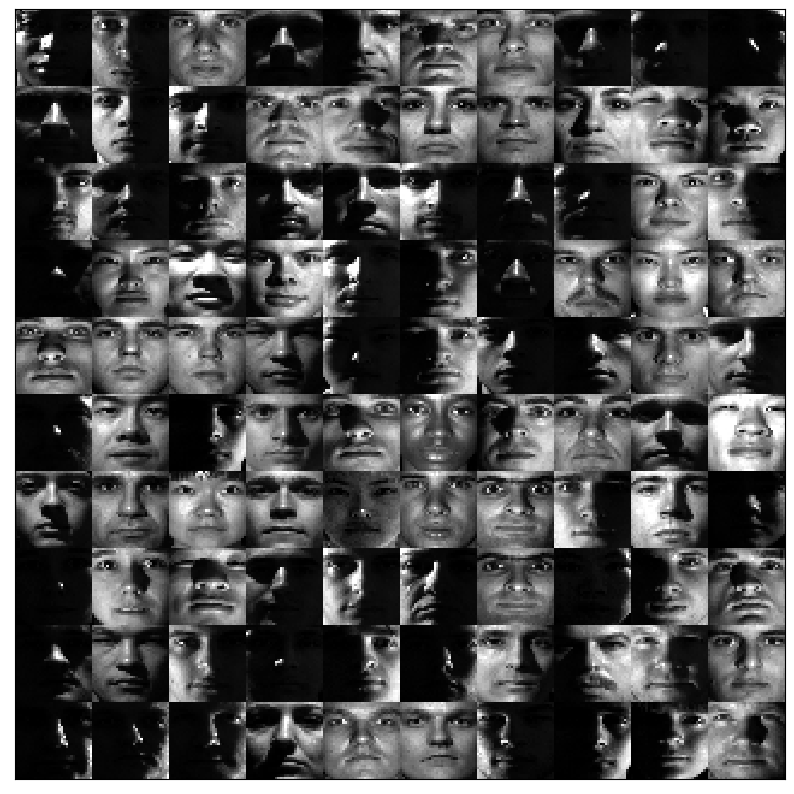

In [12]:
plt.figure(figsize=(10,10))
numx = 10
numy = 10
for i in 1:numx
    for j in 1:numy
        face = reshape(faces[rand(1:n),:], 32, 32)
        plt.imshow(face, extent=((i-1)*32,i*32,(j-1)*32,j*32), cmap="gray")
    end
end
plt.xlim((0,numx*32))
plt.ylim((0,numy*32))
plt.xticks([]);
plt.yticks([]);

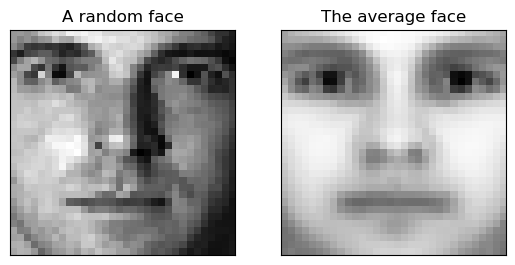

In [15]:
plt.figure()
plt.subplot(1,2,1)
display_face(faces[rand(1:size(faces)[1]),:])
plt.title("A random face")
plt.subplot(1,2,2)
display_face([Statistics.mean(faces[:,i]) for i in 1:size(faces)[2]])
plt.title("The average face");

## Finding eigenfaces with scikit-learn's PCA

In [17]:
pca = SkDecomposition.PCA()
pca.fit(faces);

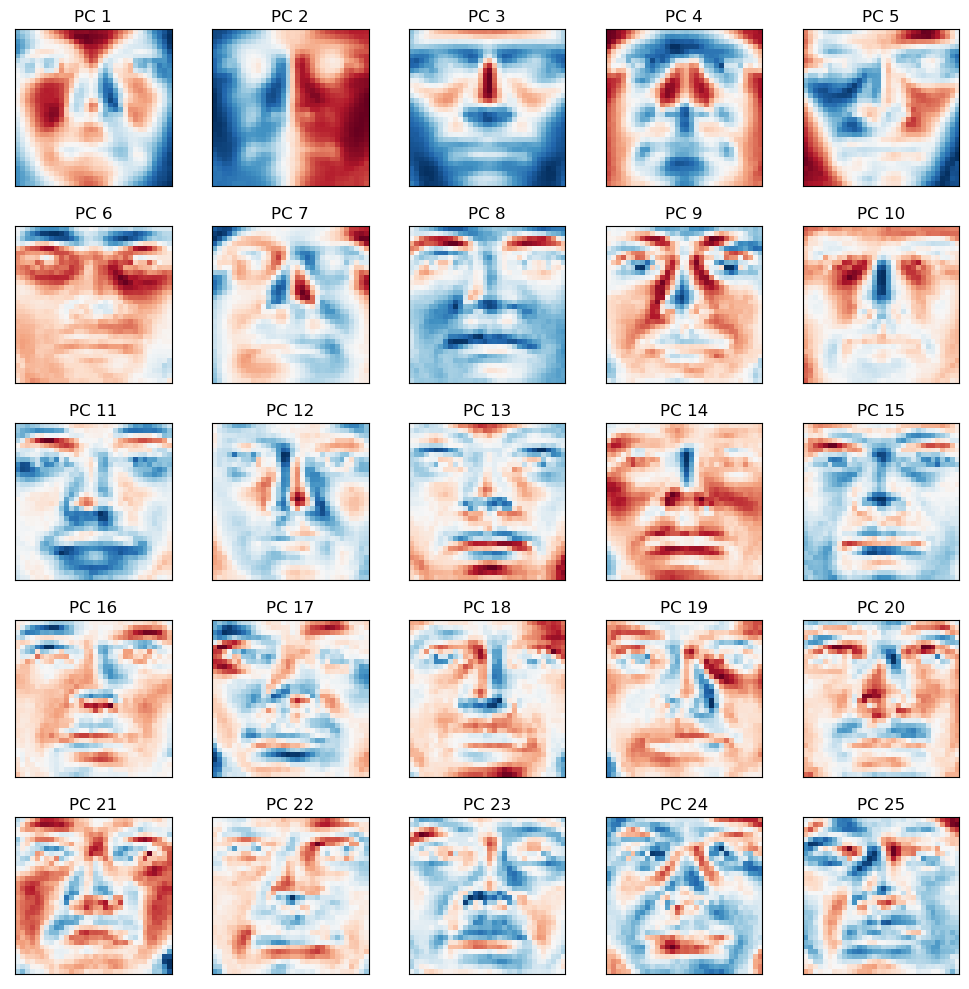

In [33]:
# show components
plt.figure(figsize=(10,10))
numx = 5
numy = 5
for i in 0:numx-1
    for j in 0:numy-1
        ind = i*numy+j
        plt.subplot(numx,numy,ind+1)
        face = reshape(pca.components_[ind+1,:], 32, 32)
        plt.imshow(face, cmap="RdBu_r", origin="upper")
        plt.xticks([]);
        plt.yticks([]);
        plt.title("PC "*string(ind+1));
    end
end
plt.tight_layout();

Above: these are "signed" images (blue is negative, red is positive?).

### Plotting the $Z$ when $k=2$

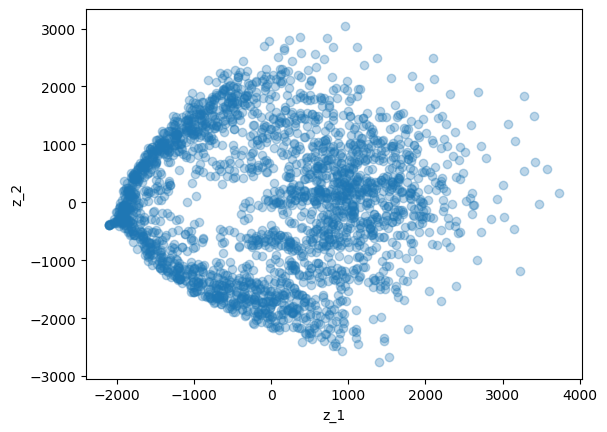

In [34]:
Z = SkDecomposition.PCA(n_components=2).fit_transform(faces)
plt.scatter(Z[:,1], Z[:,2], alpha=0.3);
plt.xlabel("z_1");
plt.ylabel("z_2");

Picking a few representative examples from this scatterplot...

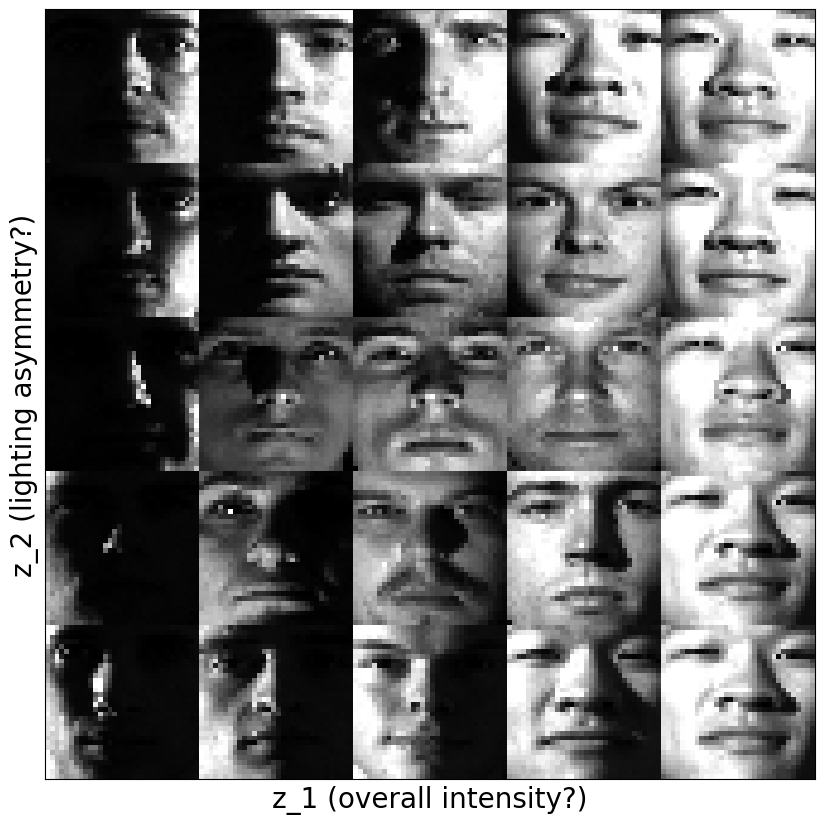

In [38]:
function index_of_closest_face_to_point(point)
    return argmin( [sum((Z[i,:]-point).^2) for i in 1:size(Z)[1]] )
end

plt.figure(figsize=(10,10))
for (i,x) in enumerate(range(minimum(Z[:,1]),stop=maximum(Z[:,1]),length=5))
    for (j,y) in enumerate(range(minimum(Z[:,2]),stop=maximum(Z[:,2]),length=5))
        idx = index_of_closest_face_to_point([x,y])
        face = reshape(faces[idx,:], 32, 32)
        plt.imshow(face, extent=((i-1)*32,i*32,(j-1)*32,j*32), cmap="gray")
    end
end
plt.xlim((0,160))
plt.ylim((0,160))
plt.xticks([])
plt.yticks([])
plt.xlabel("z_1 (overall intensity?)", fontsize=20)
plt.ylabel("z_2 (lighting asymmetry?)", fontsize=20)
plt.show()

### Variance explained?

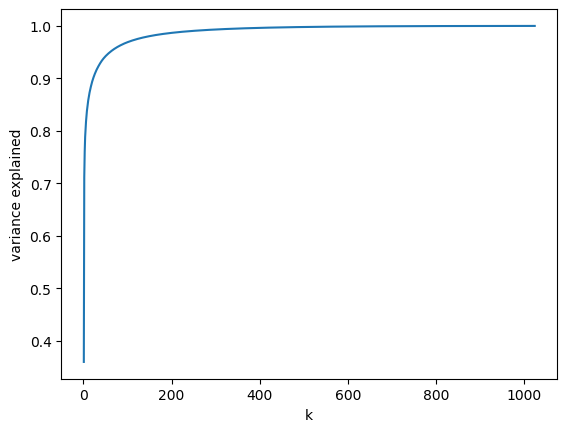

In [41]:
plt.plot(1:size(faces)[2], cumsum(pca.explained_variance_ratio_));
plt.xlabel("k");
plt.ylabel("variance explained");

### (Optional) "from scratch" implementation with SVD

In [48]:
pixel_means = [Statistics.mean(faces[:,i]) for i in 1:size(faces)[2]]'
faces_centered = faces .- pixel_means
F = LinearAlgebra.svd(faces_centered, full=false)
Z = F.U*Matrix(LinearAlgebra.Diagonal(F.S));

In [50]:
for i in 1:6
    reconstr = Z[:,1:i]*F.Vt[1:i,:]
    var_expl = 1-sum((reconstr-faces_centered).^2)/sum(faces_centered.^2)
    Printf.@printf("With %2d components, variance explained = %.0f%%\n", i, var_expl*100)
end

With  1 components, variance explained = 36%
With  2 components, variance explained = 71%
With  3 components, variance explained = 76%
With  4 components, variance explained = 79%
With  5 components, variance explained = 80%
With  6 components, variance explained = 82%


## Sparse matrix factorization

Fitting Sparse PCA
Fitting NMF


C:\Users\jasonsyc.STUDENTS.000\.julia\conda\3\lib\site-packages\sklearn\decomposition\sparse_pca.py:388: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


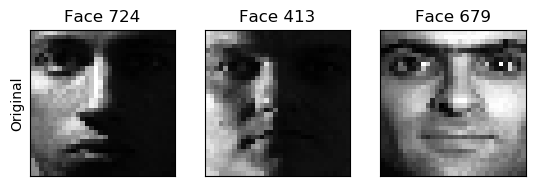

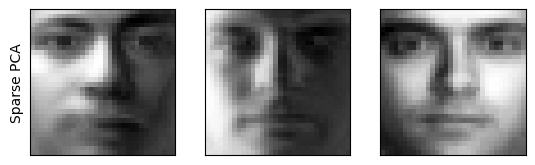

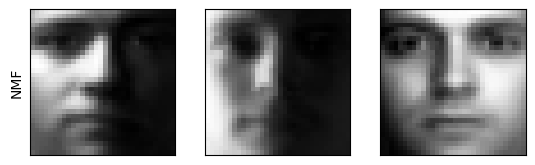

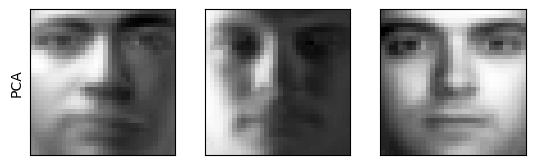

Fitting PCA


In [79]:
k = 10

models = Dict(
    "PCA"=>SkDecomposition.PCA(n_components=k), 
    "NMF"=>SkDecomposition.NMF(n_components=k), 
    "Sparse PCA"=> SkDecomposition.MiniBatchSparsePCA(n_components=k, alpha=50))

Random.seed!(10)
inds = rand(1:n, 3) # pick 3 images at random to display

plt.figure()

# Plot the original faces
for (counter, i) in enumerate(inds)
    plt.subplot(1,length(inds),counter)
    display_face(faces[i,:])
    if counter==1
        plt.ylabel("Original")
    end
    plt.title("Face $i")
end

# For each method, fit it and then plot the reconstructed faces        
for (method_name, model) in models
    println("Fitting $method_name")
    model.fit(faces)

    reconstructions = reconstruct(model, faces)

    plt.figure()
    for (counter, i) in enumerate(inds)
        plt.subplot(1,length(inds),counter)
        display_face(reconstructions[i,:])
        if counter==1
            plt.ylabel(method_name)
        end
    end
end

(can try some different values of $k$)

The reconstructions look similar, but what about the components?

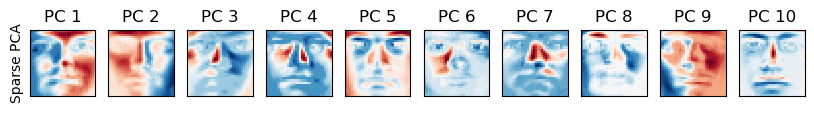

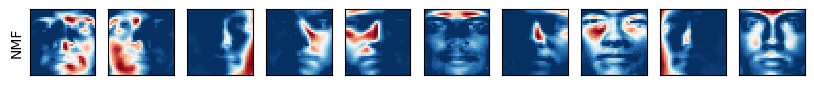

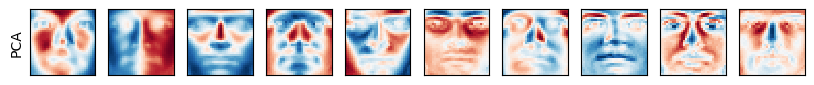

In [81]:
method_count = 0
for (method_name, model) in models
    plt.figure(figsize=(10,10))
    for i in 1:k
        plt.subplot(1,k,i)
        display_face(model.components_[i,:], cmap="RdBu_r")
        if method_count == 0
            plt.title("PC $i")
        end
        if i == 1
            plt.ylabel(method_name)
        end
    end
    method_count += 1
end

We can compute the sparsity of $Z$ and $W$:

In [84]:
for (method_name, model) in models
    println(method_name)
    Z = model.transform(faces)
    W = model.components_
    
    reconstructions = reconstruct(model, faces)
    
    Printf.@printf("  avg reconstruction error: %f\n", Statistics.mean((faces-reconstructions).^2))
    Printf.@printf("  sparsity of Z: %.2f (fraction of zeros)\n", Statistics.mean(convert(Array{Int64},broadcast(abs,Z).<1e-8)))
    Printf.@printf("  sparsity of W: %.2f (fraction of zeros)\n", Statistics.mean(convert(Array{Int64},broadcast(abs,W).<1e-8)))
    println()
end

Sparse PCA
  avg reconstruction error: 594.120052
  sparsity of Z: 0.00 (fraction of zeros)
  sparsity of W: 0.20 (fraction of zeros)

NMF
  avg reconstruction error: 597.581024
  sparsity of Z: 0.25 (fraction of zeros)
  sparsity of W: 0.34 (fraction of zeros)

PCA
  avg reconstruction error: 551.281558
  sparsity of Z: 0.00 (fraction of zeros)
  sparsity of W: 0.00 (fraction of zeros)



Given the above, what sort of regularization do you think the scikit-learn sparse PCA is using for $Z$ and $W$? 

If you're curious, see [here](https://github.com/scikit-learn/scikit-learn/blob/bac89c253b35a8f1a3827389fbee0f5bebcbc985/sklearn/decomposition/dict_learning.py#L429-L431), though it's not immediately clear that $V$ is $Z$ and $U$ is $W$ unless you look [here](https://github.com/scikit-learn/scikit-learn/blob/bac89c253b35a8f1a3827389fbee0f5bebcbc985/sklearn/decomposition/dict_learning.py#L498-L504) and [here](https://github.com/scikit-learn/scikit-learn/blob/bac89c2/sklearn/decomposition/sparse_pca.py#L178-L189) to see that they are swapped.

### Orthogonality

We can see that the components are normalized and orthogonal for PCA only.

In [273]:
i, j = randperm(k)[1:2]

for (method_name, model) in models
    println(method_name)
    W = model.components_
    Printf.@printf("  ||w_i||^2 = %s\n", dot(W[i,:],W[i,:]))
    Printf.@printf("  ||w_j||^2 = %s\n", dot(W[j,:],W[j,:]))
    Printf.@printf("  <w_i,w_j> = %s\n", dot(W[i,:],W[j,:]))
end

Sparse PCA
  ||w_i||^2 = 1.7462313834533936e8
  ||w_j||^2 = 1.4894492171964862e9
  <w_i,w_j> = 9.617239268380779e7
NMF
  ||w_i||^2 = 70057.5901535378
  ||w_j||^2 = 23624.126577773073
  <w_i,w_j> = 5215.306844910306
PCA
  ||w_i||^2 = 1.0000000000000009
  ||w_j||^2 = 0.9999999999999997
  <w_i,w_j> = -4.2327252813834093e-16


## Topic modeling demo

Adapted from demo [here](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html). This uses the [20 newsgroups dataset](https://scikit-learn.org/stable/datasets/#the-20-newsgroups-text-dataset), which is a similar idea to the newsgroups dataset in Assignment 2 (naive Bayes).

In [274]:
SkText = pyimport("sklearn.feature_extraction.text")
SkDatasets = pyimport("sklearn.datasets")

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 10

# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

dataset = SkDatasets.fetch_20newsgroups(shuffle=true, random_state=1, remove=("headers", "footers", "quotes"))


Dict{Any,Any} with 5 entries:
  "target_names" => ["alt.atheism", "comp.graphics", "comp.os.ms-windows.misc",…
  "data"         => ["Well i'm not sure about the story nad it did seem biased.…
  "filenames"    => PyObject array(['C:\\Users\\jasonsyc.STUDENTS.000\\scikit_l…
  "target"       => Int32[17, 0, 17, 11, 10, 15, 4, 17, 13, 12  …  15, 6, 5, 15…
  "DESCR"        => ".. _20newsgroups_dataset:\n\nThe 20 newsgroups text datase…

In [275]:
i = 20
println(dataset["data"][i]) # one training example 


   I'm sorry, I thought we were discussing heresy.  I assumed that heresy
meant a departure from orthodoxy, in which case generally accepted belief is
indeed an important issue.  In this case, the definition of the word "create"
is of great importance, since creation is the issue being discussed.


  I should have said "given the Mormon belief."  If you disagree with the
Mormon belief that creation is more a function of organization of eternally
existent substance than one of ex nihilo creation, then that is the important
point.


  Correction: you interpret the Bible to mean something very specific by
such terms.

   It always cracks me up when anti-Mormons presume to tell Mormons what they
believe.  Mormons do, in fact, believe that all people, including Christ and
Lucifer, are children of God in the sense that we were all created (or
organized or whatever) by Him.  We also believe that being "offspring" of
God has a symbolic sense when applied to being spiritually "born again" of
H

In [288]:
dataset["target_names"][dataset["target"][i]]

"sci.crypt"

In [292]:
data_samples = dataset["data"][1:n_samples]

# Use tf-idf features for NMF.
tfidf_vectorizer = SkText.TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features, stop_words="english")
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# Fit the NMF model
nmf = SkDecomposition.NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()

for i in 1:size(nmf.components_)[1]
    message = "Topic #$i:"
    for j in sortperm(nmf.components_[i,:])[end:-1:end-n_top_words]
        message *= " "*tfidf_feature_names[j]
        end
    println(message)
end

Topic #1: just people don think like know time good make way really
Topic #2: windows use dos using window program os drivers application help software
Topic #3: god jesus bible faith christian christ christians does heaven sin believe
Topic #4: thanks know does mail advance hi info interested email anybody looking
Topic #5: car cars tires miles 00 new engine insurance price condition oil
Topic #6: edu soon com send university internet mit ftp mail cc pub
Topic #7: file problem files format win sound ftp pub read save site
Topic #8: game team games year win play season players nhl runs goal
Topic #9: drive drives hard disk floppy software card mac computer power scsi
Topic #10: key chip clipper keys encryption government public use secure enforcement phone


┌ Warning: Deprecated syntax `implicit assignment to global variable `i``.
│ Use `global i` instead.
└ @ nothing none:0
┌ Warning: Deprecated syntax `implicit assignment to global variable `j``.
│ Use `global j` instead.
└ @ nothing none:0
┌ Warning: Loop variable `i` around In[292]:12 overwrites a variable in an enclosing scope. In the future the variable will be local to the loop instead.
└ @ nothing In[292]:12
┌ Warning: Loop variable `j` around In[292]:15 overwrites a variable in an enclosing scope. In the future the variable will be local to the loop instead.
└ @ nothing In[292]:15


In [296]:
Printf.@printf("Each topic has about %d words in it.", Statistics.mean(convert(Array{Int64},nmf.components_.!=0))*n_features)

Each topic has about 255 words in it.

In [298]:
Z = nmf.transform(tfidf)
Printf.@printf("Each article has about %.1f topics associated with it.", Statistics.mean(convert(Array{Int64},Z.!=0))*n_components)

Each article has about 2.5 topics associated with it.